# Import

In [14]:
import torch
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import os
from PIL import Image
import cv2
import supervision as sv
import numpy as np

# Set the path to the model and avoid the model file to get lost in the system file

In [15]:
grand_grand_parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
grand_parent_dir = os.path.dirname(os.getcwd())
parent_dir = os.getcwd()


# chemin complet du sous-dossier 'model'
cache_dir = os.path.join(grand_parent_dir, "model")

# Crée le dossier et tous les parents manquants si besoin
os.makedirs(cache_dir, exist_ok=True)

model_path = os.path.join(grand_parent_dir, "model")

# Load the image

In [16]:
image_brg = cv2.imread("dog.png")
image_rgb =cv2.cvtColor(image_brg, cv2.COLOR_BGR2RGB)

# Load the model

In [17]:
sam = sam_model_registry["vit_b"](
    checkpoint="./model/sam_vit_b_01ec64.pth",
    ).to('cpu')

# Generate all mask

In [ ]:
#sam.float()
#predictor = SamPredictor(sam)
#predictor.model = predictor.model.float()

mask_generator = SamAutomaticMaskGenerator(sam)
#predictor = SamPredictor(sam)
#predictor.set_image(image_rgb)
#masks, _, _ = predictor.predict("a dog")

sam_result = mask_generator.generate(image_rgb)

# Inspect and merge the mask that we want 

In [39]:
# Example: pick masks covering the face, arms, clothes, etc.
# One simple heuristic: pick largest masks near the image center.
# Here’s how to merge the top N masks by area:
masks = sorted(sam_result, key=lambda x: x['area'], reverse=True)

# For example, take top 5 masks (tune as needed!)
selected_masks = [m['segmentation'] for m in masks[:2]]

# Combine the selected mask into one

In [40]:
# Combine them into one mask
combined_mask = np.zeros_like(selected_masks[0], dtype=np.uint8)
for m in selected_masks:
    combined_mask = np.logical_or(combined_mask, m)


# Apply the combine mask to one

In [41]:
# === 5) Apply combined mask to the image ===
masked_image = np.zeros_like(image_rgb)
masked_image[combined_mask] = image_rgb[combined_mask]

# Save and show 

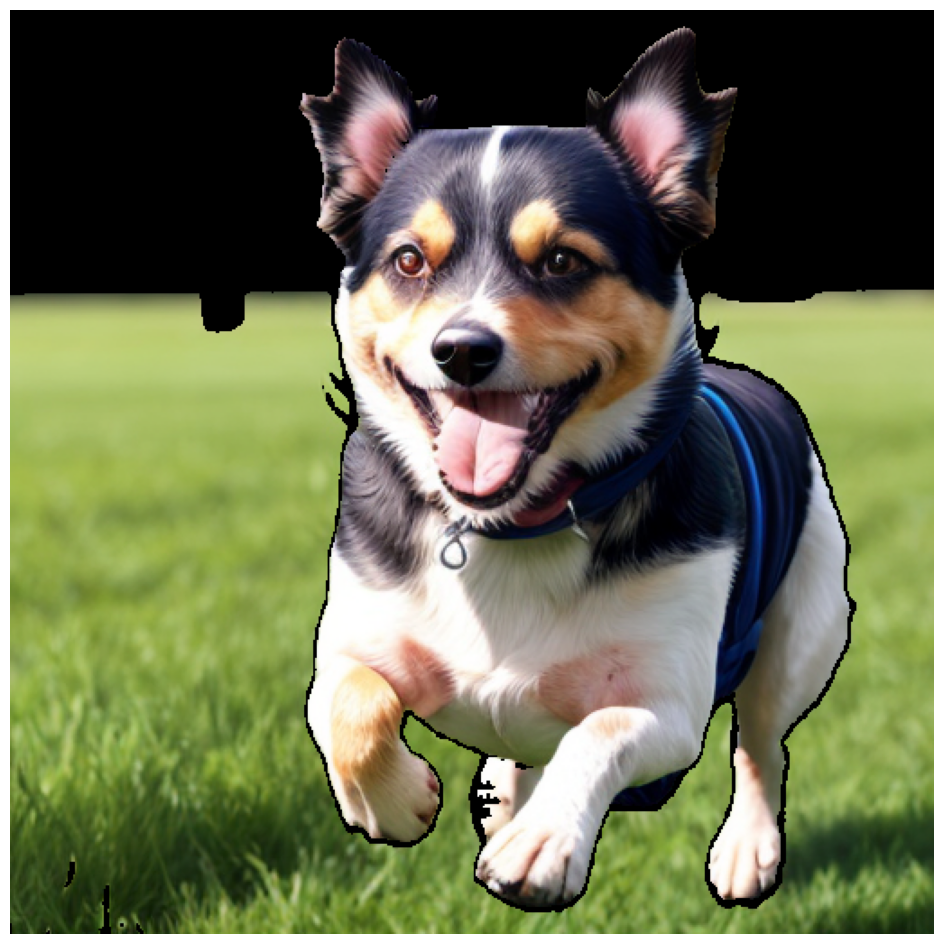

In [42]:
result_bgr = cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("foreground.png", result_bgr)
sv.plot_image(result_bgr)

# Compare the image and the segmented image

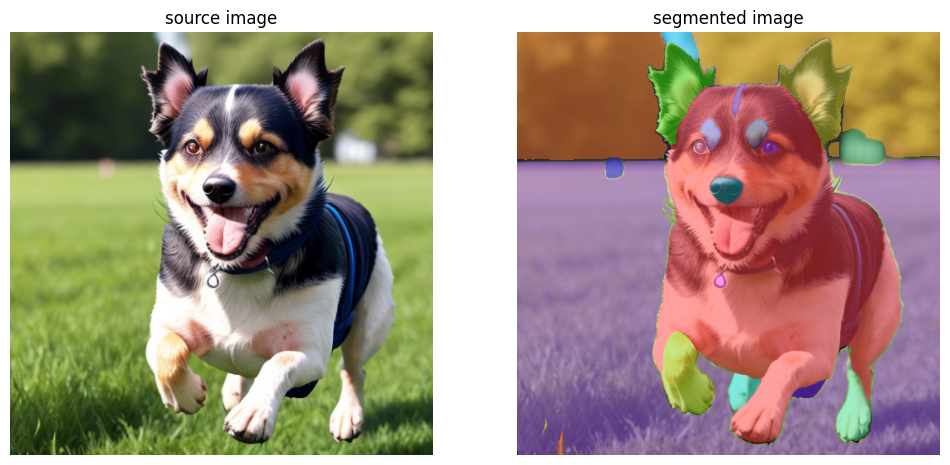

In [43]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_brg.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_brg, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)